# Chapter 24: TP Roll I (Rotational Motion)

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [1]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *

In this chapter and the next we'll model systems that involve rotating objects.
In general, rotation is complicated.
In three dimensions, objects can rotate around three axes and many objects are easier to spin around some axes than others.
If the configuration of an object changes over time, it might become
easier or harder to spin, which explains the surprising dynamics of
gymnasts, divers, ice skaters, etc.
And when you apply a twisting force to a rotating object, the effect is often contrary to intuition. 
For an example, see this video on gyroscopic precession: <http://modsimpy.com/precess>.

We will not take on the physics of rotation in all its glory; rather, we will focus on simple scenarios where all rotation and all twisting forces are around a single axis. 
In that case, we can treat some vector quantities as if they were scalars; that is, simple numbers.

The fundamental ideas in these examples are angular velocity, angular acceleration, torque, and moment of inertia.
If you are not already familiar with these concepts, don't worry; I will define them as we go along, and I will point to additional reading.

## The Physics of Toilet Paper

As an example of a system with rotation, we'll simulate the manufacture of a roll of toilet paper, as shown in this video: <https://youtu.be/Z74OfpUbeac?t=231>. 
Starting with a cardboard tube at the center, we will roll up 47 m of paper, a typical length for a roll of toilet paper in the U.S. (see <http://modsimpy.com/paper>).

The following figure shows a diagram of the system: $r$ represents
the radius of the roll at a point in time. Initially, $r$ is the radius of the cardboard core, $R_{min}$. When the roll is complete, $r$ is $R_{max}$.

![Diagram of a roll of toilet paper, showing change in paper length as a result of a small rotation, $d\theta$.](https://github.com/AllenDowney/ModSim/raw/main/figs/paper_roll.png)

I'll use $\theta$ to represent the total rotation of the roll in radians. In the diagram, $d\theta$ represents a small increase in $\theta$, which corresponds to a distance along the circumference of $r~d\theta$.

I'll use $y$ to represent the total length of paper that's been rolled. 
Initially, $\theta=0$ and $y=0$. 
For each small increase in $\theta$, there is a corresponding increase in $y$: 

$$dy = r~d\theta$$

If we divide both sides by a small increase in time, $dt$, we get a
differential equation for $y$ as a function of time.

$$\frac{dy}{dt} = r \frac{d\theta}{dt}$$ 

As we roll up the paper, $r$ increases. Assuming it increases by a fixed amount per revolution, we can write 

$$dr = k~d\theta$$ 

Where $k$ is an unknown constant we'll have to figure out. 
Again, we can divide both sides by $dt$ to get a differential equation in time:

$$\frac{dr}{dt} = k \frac{d\theta}{dt}$$ 

Finally, let's assume that $\theta$ increases at a constant rate of $\omega = 300$ rad/s (about 2900 revolutions per minute): 

$$\frac{d\theta}{dt} = \omega$$ 

This rate of change is called an *angular velocity*. Now we have a system of differential equations we can use to simulate the system.

## Setting Parameters

Here are the parameters of the system:

In [2]:
Rmin = 0.02      # m
Rmax = 0.055     # m
L = 47           # m
omega = 300      # rad / s

`Rmin` and `Rmax` are the initial and final values for the radius, `r`.
`L` is the total length of the paper.
`omega` is the angular velocity in radians per second.

Figuring out `k` is not easy, but we can estimate it by pretending that `r` is constant and equal to the average of `Rmin` and `Rmax`:

In [3]:
Ravg = (Rmax + Rmin) / 2

In that case, the circumference of the roll is also constant:

In [4]:
Cavg = 2 * np.pi * Ravg

And we can compute the number of revolutions to roll up length `L`, like this.

In [5]:
revs = L / Cavg

Converting rotations to radians, we can estimate the final value of `theta`.

In [6]:
theta = 2 * np.pi * revs
theta

1253.3333333333335

Finally, `k` is the total change in `r` divided by the total change in `theta`.  That is, it is the change in thickness of the paper per radian turned--for each radian turned, then, the radius increases by `k`.

In [7]:
k_est = (Rmax - Rmin) / theta
k_est

2.7925531914893616e-05

At the end of the chapter, we'll derive `k` analytically, but this estimate is enough to get started.

## Simulating the System

The state variables we'll use are, `theta` (the rotational position defined in radians--how far has the roll turned since t = 0), `y` (the length of paper on the roll), and `r` (the radius of the roll at a given instant).

Here are the initial conditions:

In [8]:
init = State(theta=0, y=0, r=Rmin)

And here's a `System` object with `init` and `t_end`:

In [9]:
system = System(init=init, t_end=10)

Now we can use the differential equations from the previous section to
write a slope function.  Remember we derived these two differential equations:

$$\frac{dy}{dt} = r \frac{d\theta}{dt}$$ 

$$\frac{dr}{dt} = k \frac{d\theta}{dt}$$ 

We then defined constant angular velocity as $\omega$:

$$\frac{d\theta}{dt} = \omega$$ 

If we sub this definition of $\omega$ in into the DEs above, we get:

$$\frac{dy}{dt} = r \omega$$ 

$$\frac{dr}{dt} = k \omega$$

These are the definitions we'll use in our slope function:

In [10]:
def slope_func(t, state, system):
    theta, y, r = state
    
    dydt = r * omega
    drdt = k_est * omega
    
    return omega, dydt, drdt

As usual, the slope function takes a time stamp, a `State` object, and a `System` object. 

The job of the slope function is to compute the time derivatives of the state variables--that is, how much each variable changes with time.

And as usual, we'll test the slope function with the initial conditions.

In [11]:
slope_func(0, system.init, system)

(300, 6.0, 0.008377659574468085)

We'd like to stop the simulation when the length of paper on the roll is `L`. We can do that with an event function that passes through 0 when `y` equals `L`:

In [12]:
def event_func(t, state, system):
    theta, y, r = state
    return L - y

We can test it with the initial conditions:

In [13]:
event_func(0, system.init, system)

47.0

Now let's run the simulation:

In [14]:
results, details = run_solve_ivp(system, slope_func,
                                  events=event_func)
details.message

'A termination event occurred.'

Here are the last few time steps.

In [15]:
results.tail()

,theta,y,r
4.010667,1203.200000,44.277760,0.05360
4.052444,1215.733333,44.951740,0.05395
4.094222,1228.266667,45.630107,0.05430
4.136000,1240.800000,46.312860,0.05465
4.177778,1253.333333,47.000000,0.05500


The time it takes to complete one roll is about 4.2 seconds, which is consistent with what we see in the video.

In [16]:
results.index[-1]

4.177777777777779

The final value of `y` is 47 meters, as expected.

In [17]:
final_state = results.iloc[-1] 
final_state.y

47.000000000000014

The final value of radius is 0.55 m, which is `Rmax`.

In [18]:
final_state.r

0.05500000000000001

The total number of rotations is close to 200, which seems plausible.

In [19]:
radians = final_state.theta
rotations = radians / 2 / np.pi
rotations

199.47419534184218

As an exercise, we'll see how fast the paper is moving.  But first, let's take a closer look at the results.

## Plotting the Results

Here's what `theta` looks like over time.

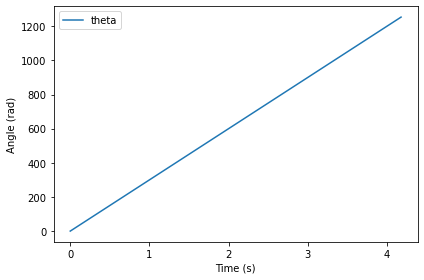

In [20]:
def plot_theta(results):
    results.theta.plot(color='C0', label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    
plot_theta(results)

`theta` grows linearly, as we should expect with constant angular velocity.  A constant omega is analagous to a constant straight-line velocity: if I am travelling at 20 m/s, then my position will change linearly with time, just as my angular position changes linearly here.

Here's what `r` looks like over time.

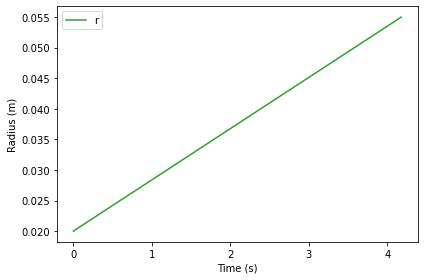

In [21]:
def plot_r(results):
    results.r.plot(color='C2', label='r')

    decorate(xlabel='Time (s)',
             ylabel='Radius (m)')
    
plot_r(results)

`r` also increases linearly.  If this seems strange, you may be confusing angular and straight-line velocities (the latter is called *linear velocity*, but I'm avoiding using that *linear* in this second way here).  Our roll has a constant angular velocity: the time it takes to do one rotation, then, stays the same throughout the simulation, and each rotation adds one layer of paper.   So the thickness increases linearly with time.

But the straight-line velocity of the paper changes as the roll gets thicker ($\frac {dy}{dt} = r \omega$): each rotation requires more paper, so the straight-line velocity has to increase over time.

Here's what `y` looks like over time.

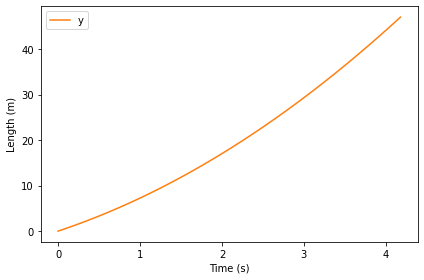

In [22]:
def plot_y(results):
    results.y.plot(color='C1', label='y')

    decorate(xlabel='Time (s)',
             ylabel='Length (m)')
    
plot_y(results)

Since the derivative of `y` depends on `r`, and `r` is increasing, `y` grows with increasing slope.

In the next section, we'll see that we could have solved these differential equations analytically.
However, it is often useful to start with simulation as a way of exploring and checking assumptions.

## Analytic Solution

The angular velocity is constant in our simulation: 

$$\frac{d\theta}{dt} = \omega$$ 

Remember that a first order DE with a constant on the right hand side is a linear equation: the DE simply says that the rate of change is constant.   So we can find $\theta$ as a function of time by integrating both sides, and we'll get a nice linear equation:

$$\theta(t) = \omega t$$ 

I've left off the constant of integration since $\theta = 0$ when $t = 0$.  



Similarly, we can solve this linear DE:

$$\frac{dr}{dt} = k \omega$$

to find another linear equation for the radius as a function of time:

$$r(t) = k \omega t + R_{min}$$ 

Here the constant of integration is $R_{min}$, because when $t = 0$, $r = R_{min}$.



Finally, we can plug the solution for $r$ into the differential equation for $y$: 

$$\frac{dy}{dt}  = r \omega$$             
$$\frac{dy}{dt}  = \left[ k \omega t + R_{min} \right] \omega = k \omega^2 t + R_{min} \omega$$
              
In this equation, everything is constant except for the variable $t$.  If we integrate both sides of this equation with respect to $t$, we get a squared term with the variable $t$:

$$y(t) = \frac {1}{2}k \omega^2 t^2 + R_{min} \omega t + C$$ 

Notice that this equation is of the form $y(t) = At^2 + Bt + C$: so $y$ is a parabola.  The constant of integration $C$ is equal to zero, since $y$ is 0 when the simulation starts (i.e. $t = 0$).

## Summary

This chapter introduces rotation, starting with an example where angular velocity is constant.
We simulated the manufacture of a roll of toilet paper, then we solved the same problem analytically.

In the next chapter, we'll see a more interesting example where angular velocity is not constant.  And we'll introduce three new concepts: torque, angular acceleration, and moment of inertia.

### Exercise 1

 Since we keep `omega` constant, the linear velocity of the paper $\frac{dy}{dt}$ increases with radius.  On a position vs. time plot like the $y$ vs. $t$ plot above, the linear velocity is the slope of line, since slope is another way to talk about rate of change.  In this sense, we could translate the equation $\frac{dy}{dt} = r\omega$ as "the slope of the line on a $y$ vs. $t$ plot is $r(t)\omega$", remembering that $r$ changes with time.
 
If we plotted the slope vs $t$, then, we will find that the slope increases linearly, because $r\omega$ increases linearly.   Another term for slope is *gradient*, and we can use `gradient` to estimate the slope of `results.y`.

In [23]:
dydt = gradient(results.y)

Here's what the result looks like.

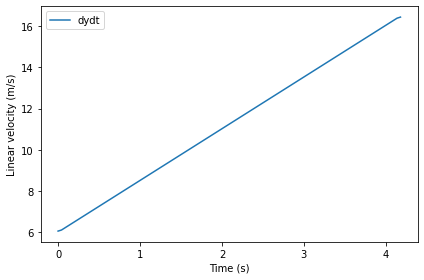

In [24]:
dydt.plot(label='dydt')
decorate(xlabel='Time (s)',
         ylabel='Linear velocity (m/s)')

With constant angular velocity, linear velocity is increasing, reaching its maximum at the end.

In [25]:
max_linear_velocity = dydt.iloc[-1]
max_linear_velocity

16.4475000000001

Now suppose this peak velocity is the limiting factor; that is, we can't move the paper any faster than that.
In that case, we might be able to speed up the process by keeping the linear velocity at the maximum all the time.

Write a slope function that keeps the linear velocity, `dydt`, constant, and computes the angular velocity, `omega`, accordingly.
Then, run the simulation and see how much faster we could finish rolling the paper.

We start with the same two differential equations:

$$\frac{dy}{dt} = r \frac{d\theta}{dt}$$ 


$$\frac{dr}{dt} = k \frac{d\theta}{dt}$$

But we can't simply replace $\frac{d\theta}{dt}$ with $\omega$.  Instead, we can replace $\frac{dy}{dt}$ with $v$, our constant linear velocity:

$$\frac{d\theta}{dt} = v/r$$ 


$$\frac{dr}{dt} = k \frac{d\theta}{dt}$$

$k$ is still defined in units of $m/rad$, so it is still a constant, even thought thickness will not increase linearly in this situation.


In [26]:
# Set the parameters, replacing a constant omega with a constant v = 16.45
# and create a system

Rmin = 0.02      # m
Rmax = 0.055     # m
L = 47           # m
v = 16.45        # m / s
k_est = 2.79e-05     # m / rad

init1 = State(theta=0, y=0, r=Rmin)
system1 = System(init=init1, t_end=10)

In [27]:
# Define and test a slope function

def slope_func(t, state, system):
    theta, y, r = state
    
    d0dt = v/r
    drdt = k_est * d0dt
    
    return d0dt, v, drdt

slope_func(0,system1.init,system1)

(822.5, 16.45, 0.02294775)

In [28]:
# Define and test an event function
def event_func(t, state, system):
    theta, y, r = state
    return L - y

event_func(0,system1.init,system1)

47.0

In [29]:
# Solve the system
results1, details = run_solve_ivp(system1, slope_func,
                                  events=event_func)
details.message

'A termination event occurred.'

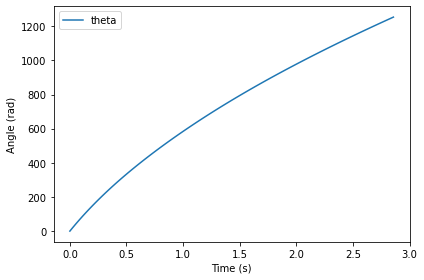

In [30]:
# Plot r, y, and theta to check your results: Do they makes sense?
plot_theta(results1)
#plot_r(results1)
#plot_y(results1)

In [31]:
# Determine how much faster the constant velocity process is
print('The constant velocity process is ',
      results.index[-1] - results1.index[-1],
      'seconds faster than the constant omega process')

The constant velocity process is  1.3206349206349213 seconds faster than the constant omega process
